In [34]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.datasets import boston_housing
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
import tensorflow as tf
import pandas as pd

In [35]:
teste = pd.read_csv("datasets/Classification/Corona_NLP_test.csv")
treino = pd.read_csv("datasets/Classification/Corona_NLP_train.csv",encoding='latin-1')

data = pd.concat([teste,treino])
data = data.sample(frac=0.2, random_state=42)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8991 entries, 29256 to 21571
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       8991 non-null   int64 
 1   ScreenName     8991 non-null   int64 
 2   Location       7135 non-null   object
 3   TweetAt        8991 non-null   object
 4   OriginalTweet  8991 non-null   object
 5   Sentiment      8991 non-null   object
dtypes: int64(2), object(4)
memory usage: 491.7+ KB


In [36]:
data = data.drop(columns=[ "UserName","ScreenName","Location","TweetAt"], axis=1)

In [37]:
def categorize_sentiment(score):
    if score == 'Negative':
        return "Negative"
    elif score == 'Extremely Negative':
        return "Negative"
    elif score == 'Positive':
        return "Positive"
    elif score == 'Extremely Positive':
        return "Positive"
    else:
        return "Neutral"
    
    
data['Sentiment'] = data['Sentiment'].apply(categorize_sentiment)

In [38]:
# Fazer TOKENIZACAO das palavras
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def get_all_str(tweet):
    sentence = ''
    for words in tweet:
        sentence += words
    sentence = sentence.lower()
    return sentence
def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

def get_hashtag(text):
    result = nltk.RegexpTokenizer(r'(?<=#)\w+').tokenize(text.lower())
    return result

def get_mention(text):
    result = nltk.RegexpTokenizer(r'(?<=@)\w+').tokenize(text.lower())
    return result 

def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

def remove_stopword(stopwords, lst):    
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
#     print(stoplist)
    return cleanwordlist

def pos_remove_noun(tagged):
    remove_noun = [word for word,pos in tagged if pos not in ['NN','NNS','NNP','NNPS']]
    txt = ''
    for i in range(len(remove_noun)):
        txt += remove_noun[i]
        txt += '\n'
    return cleanwordlist

def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
#     txt= ' '.join(tokens)
    return tokens

In [40]:
def preprocessing(text):
    words = get_word(text)
    lemma = lemmatization(words)
    removed = remove_stopword(['http','ly'],lemma)
    return removed

data['OriginalTweet'] = data['OriginalTweet'].apply(preprocessing)
data['OriginalTweet'] = data['OriginalTweet'].apply(get_str)

In [41]:
X = data.drop(columns=["Sentiment"])
y = data["Sentiment"]

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf = TfidfVectorizer(stop_words='english', norm='l2' )
X = Tfidf.fit_transform(X["OriginalTweet"])

In [15]:
from sklearn.preprocessing import  LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [32]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
y

array([0, 2, 0, ..., 0, 2, 2])

In [17]:
# Load the Boston Housing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
from keras.optimizers import Adam, SGD
from keras.layers import Dense, BatchNormalization, Dropout, LayerNormalization
from keras.regularizers import l2

from keras.initializers import glorot_uniform
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)

def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

57/57 [==============================] - 0s 6ms/step - loss: 1.8521 - accuracy: 0.6643
Loss: 1.8520766496658325, Accuracy: 0.6642579436302185
57/57 [==============================] - 1s 8ms/step - loss: 1.9367 - accuracy: 0.6935
Loss: 1.9367033243179321, Accuracy: 0.6935483813285828
57/57 [==============================] - 0s 6ms/step - loss: 1.8267 - accuracy: 0.6735
Loss: 1.8266749382019043, Accuracy: 0.6735261678695679
57/57 [==============================] - 0s 6ms/step - loss: 1.8942 - accuracy: 0.6691
Loss: 1.8942177295684814, Accuracy: 0.6690767407417297
57/57 [==============================] - 0s 6ms/step - loss: 1.7968 - accuracy: 0.6813
Loss: 1.7967900037765503, Accuracy: 0.6813125610351562


In [19]:

def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

57/57 [==============================] - 0s 5ms/step - loss: 2.0426 - accuracy: 0.6615
Loss: 2.042646884918213, Accuracy: 0.661478579044342
57/57 [==============================] - 0s 5ms/step - loss: 1.8776 - accuracy: 0.6835
Loss: 1.877558708190918, Accuracy: 0.6835372447967529
57/57 [==============================] - 0s 4ms/step - loss: 2.0319 - accuracy: 0.6630
Loss: 2.0319480895996094, Accuracy: 0.6629588603973389
57/57 [==============================] - 0s 5ms/step - loss: 2.0873 - accuracy: 0.6730
Loss: 2.087348461151123, Accuracy: 0.6729699373245239
57/57 [==============================] - 0s 5ms/step - loss: 1.9946 - accuracy: 0.6824
Loss: 1.9945584535598755, Accuracy: 0.6824249029159546


# Modelos completos apartir do softmax


In [21]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:

def create_model():
    model = Sequential()
    model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='selu'))
    model.add(Dense(16, activation='selu',kernel_initializer=glorot_uniform(seed = 50)))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

KeyboardInterrupt: 

In [ ]:
def create_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:]))
    model.add(Dense(64, activation='selu',kernel_initializer=glorot_uniform(seed = 50)))
    model.add(Dense(16, activation='selu',kernel_initializer=glorot_uniform(seed = 50)))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')


57/57 [==============================] - 0s 5ms/step - loss: 2.1438 - accuracy: 0.6609
Loss: 2.143805980682373, Accuracy: 0.6609227061271667
57/57 [==============================] - 0s 4ms/step - loss: 1.9749 - accuracy: 0.6880
Loss: 1.9749473333358765, Accuracy: 0.6879866719245911
57/57 [==============================] - 0s 3ms/step - loss: 2.0984 - accuracy: 0.6802
Loss: 2.0983948707580566, Accuracy: 0.6802002191543579
57/57 [==============================] - 0s 3ms/step - loss: 2.1669 - accuracy: 0.6758
Loss: 2.1669068336486816, Accuracy: 0.6757508516311646
57/57 [==============================] - 0s 3ms/step - loss: 2.0533 - accuracy: 0.6752
Loss: 2.053319215774536, Accuracy: 0.6751946806907654


<function matplotlib.pyplot.show(close=None, block=None)>

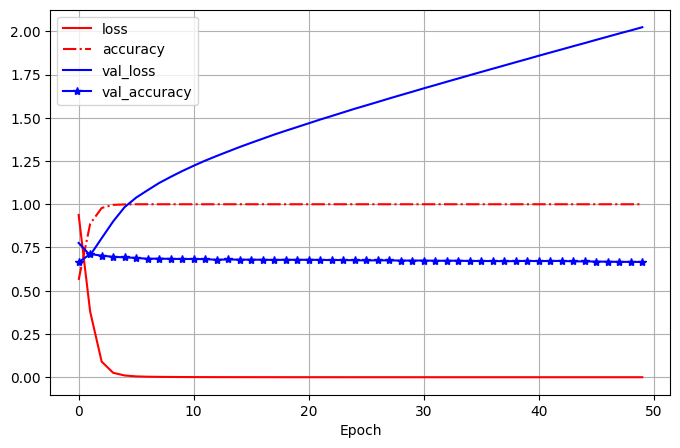

In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

def evaluation_parametrics(name,y_test, y_pred):
    cm_test = confusion_matrix(y_test, y_pred )
    t1 = ConfusionMatrixDisplay(cm_test, display_labels=["Negative","Positive","Neutral"])    
    print("Classification Report for Data Test")
    print(classification_report(y_test, y_pred))
    t1.plot()

evaluation_parametrics('sim',y_test,y_pred)
    

57/57 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

57/57 [==============================] - 0s 2ms/step


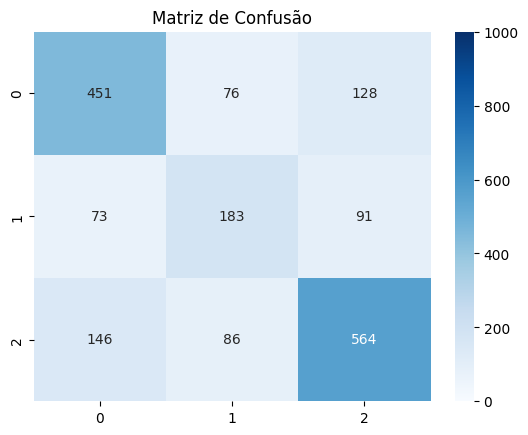

In [ ]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
    

sum = cm.sum()

df_cm = pd.DataFrame(cm, index = [0, 1, 2], columns = [0, 1, 2])

res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=1000.0,  cmap=plt.cm.Blues, fmt='g')
plt.yticks([0.5,1.5,2.5], [0, 1, 2],va='center')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='relu'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='selu'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
from tensorflow.keras.layers import LeakyReLU

def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='sigmoid'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='softplus'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
# def create_model():
#     model = Sequential()
#     model.add(Dense(16, input_dim=X.shape[1], activation='relu', kernel_initializer=glorot_uniform()))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2, seed=42))
#     model.add(Dense(16, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2, seed=42))
#     model.add(Dense(len(np.unique(y)), activation='crossentropy'))
#     model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#     return model

In [ ]:
train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy}')

In [ ]:
X_new = X_test[0:10]
y_preds = model.predict(X_new)
y_preds.round(2)

In [ ]:
y_test[0:10]

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show